/home/tianqi/miniconda3/envs/fif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



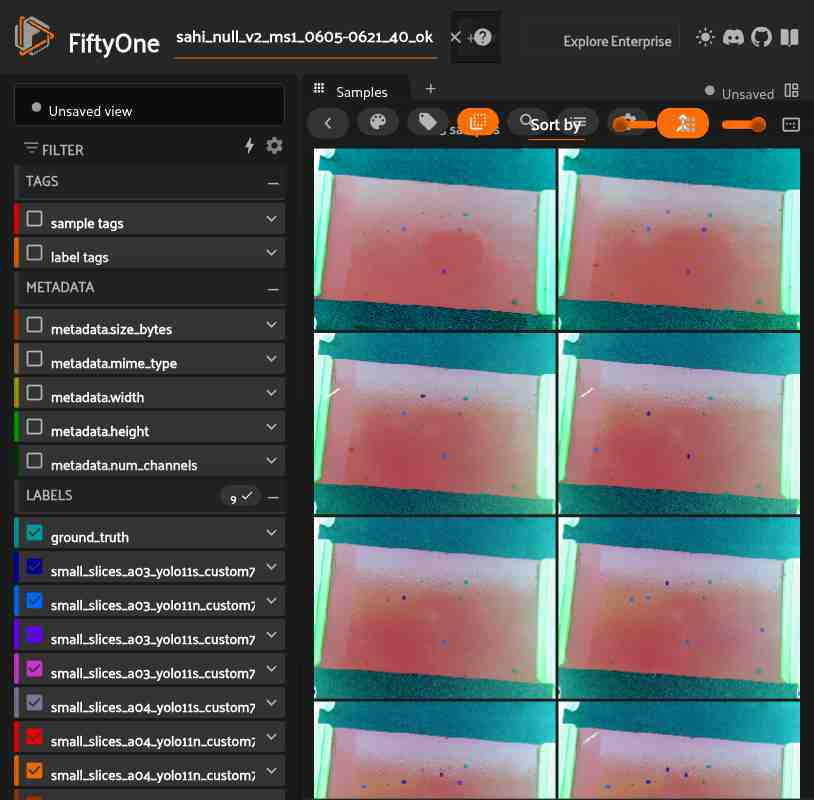

In [ ]:
import fiftyone as fo  

# 加载已存在的数据集  
dataset = fo.load_dataset("my-dataset")
session = fo.launch_app(dataset)

## 使用模型推理---sahi小图

In [2]:
# %% =========================
# 0) Imports
# =========================
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple, Any

import pandas as pd
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone import ViewField as F

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction



### User Config

In [3]:
# %% =========================
# 1) User Config
# =========================
data_root = Path("/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone")
target_subdir_name = Path("data")

version = "sahi_null_v2"

# 多模型：直接在这里放 .pt
model_root = Path("/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/02_models/best_models/04_swd_hbb") 
model_names = [
    # "a02_yolo11s_custom7_v2-13_7_34_36-40_10-11_8.pt",
    # "a02_yolo11s_custom7_v2-13_7_34_36-40_10-11_4.pt",
    # "a02_yolo11s_custom7_v1-34_36_40_11_-13-10_16.pt",
    # "a02_yolo11s_custom7_v4-36_40_10_11-7_34-13_16.pt",
    # "a02_yolo11s_custom7_v4-36_40_10_11-7_34-13_8.pt",
    "a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16.pt",
    "a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8.pt",
    "a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8.pt",
    "a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_4.pt",
    "a04_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16.pt",
    "a04_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_4.pt",
    "a04_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8.pt",
    "a04_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8.pt",
]

ckpt_paths = [str(model_root / name) for name in model_names]

# SAHI slicing overlap
sahi_kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}
slice_height = 640
slice_width = 640

# Evaluate thresholds
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93]

# COCO label path under each subdir_path (you used this name)
coco_json_name = "org_label_no_overlap.json"

# category map (optional; COCO can also infer)
categories = {1: "swd"}

# 输出汇总文件
out_dir = Path("./_eval_exports")
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / f"eval_summary__{version}.csv"
out_xlsx = out_dir / f"eval_summary__{version}.xlsx"



### Helpers

In [4]:
# %% =========================
# 2) Helpers
# =========================
def fetch_subsequent_dir(data_root: Path, target_subdir_name: Path) -> Tuple[List[Path], List[str]]:
    data_paths = list(data_root.glob(f"*/{target_subdir_name}"))
    subdir_path_list = [data_path.parent for data_path in data_paths]
    subdir_name_list = [subdir.name for subdir in subdir_path_list]
    return subdir_path_list, subdir_name_list


def model_tag_from_path(p: str) -> str:
    # 字段名建议只用 stem，避免空格和奇怪字符
    return Path(p).stem

def ensure_pred_field(dataset: fo.Dataset, pred_field: str) -> None:
    if pred_field not in dataset.get_field_schema():
        dataset.add_sample_field(
            pred_field,
            fo.EmbeddedDocumentField,
            embedded_doc_type=fo.Detections,
        )

def predict_with_slicing(sample: fo.Sample, detection_model: AutoDetectionModel, label_field: str, **kwargs) -> None:
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    ensure_pred_field(dataset, label_field)
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


def ensure_dataset_with_gt(subdir_path: Path, subdir_name: str, version: str) -> fo.Dataset:
    """
    方案B：dataset 只创建一次，GT 也只导入一次
    """
    ds_name = f"{version}_{subdir_name}"

    if ds_name in fo.list_datasets():
        dataset = fo.load_dataset(ds_name)
        return dataset

    dataset = fo.Dataset.from_images_dir(
        str(subdir_path / "data"),
        name=ds_name
    )

    coco_path = subdir_path / coco_json_name
    if not coco_path.exists():
        raise FileNotFoundError(f"COCO JSON not found: {coco_path}")

    fouc.add_coco_labels(
        dataset,
        label_field="ground_truth",
        labels_or_path=str(coco_path),
        categories=categories,
        label_type="detections",
    )

    return dataset

def run_inference_for_model(dataset: fo.Dataset, ckpt_path: str, pred_field: str) -> None:
    """
    对 dataset 跑一个模型的 SAHI slicing 推理，并写入 pred_field
    """
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=ckpt_path,
        confidence_threshold=0.1,
        image_size=640,
        device="cuda",
    )

    for sample in dataset.iter_samples(progress=True, autosave=True):
        predict_with_slicing(
            sample,
            detection_model=detection_model,
            label_field=pred_field,
            slice_height=slice_height,
            slice_width=slice_width,
            **sahi_kwargs
        )


def evaluate_model_fields(
    dataset: fo.Dataset,
    ds_name: str,
    subdir_path: Path,
    ckpt_path: str,
    model_tag: str,
    pred_field: str,
    thresholds: List[float],
) -> List[Dict[str, Any]]:
    """
    对某个 pred_field（某个模型）在多个置信度阈值下评估，返回 rows
    """
    rows: List[Dict[str, Any]] = []

    gt_count = dataset.count("ground_truth.detections")
    total_pred_count = dataset.count(f"{pred_field}.detections")

    for thr in thresholds:
        view = dataset.filter_labels(
            pred_field, F("confidence") > thr, only_matches=False
        )

        new_model_tag = model_tag.replace("-", "__")

        eval_key = f"eval_{new_model_tag}_conf_{int(thr * 100)}"
        res = view.evaluate_detections(
            pred_field,
            gt_field="ground_truth",
            compute_mAP=True,
            eval_key=eval_key
        )

        pred_count_thr = view.count(f"{pred_field}.detections")
        metrics = res.metrics()

        row = {
            "dataset_name": ds_name,
            "subdir_name": ds_name.replace(f"_{version}", ""),
            "subdir_path": str(subdir_path),
            "version": version,

            "model_tag": model_tag,
            "ckpt_path": ckpt_path,
            "pred_field": pred_field,

            "confidence_threshold": thr,

            "gt_count": int(gt_count),
            "pred_count_total": int(total_pred_count),
            "pred_count_at_threshold": int(pred_count_thr),

            "mAP": float(res.mAP()),
            "precision": float(metrics.get("precision", float("nan"))),
            "recall": float(metrics.get("recall", float("nan"))),
            "f1": float(metrics.get("f1", float("nan"))),
        }
        rows.append(row)

    return rows




### Discover subdirs

In [5]:
# %% =========================
# 3) Discover subdirs
# =========================
subdir_path_list, subdir_name_list = fetch_subsequent_dir(data_root, target_subdir_name)
print("Found subdirs:", len(subdir_name_list))
for n, p in zip(subdir_name_list, subdir_path_list):
    print(n, p)


Found subdirs: 7
ms2_0726-0809_13_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms2_0726-0809_13_ok
sw1_0605-0613_07_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/sw1_0605-0613_07_ok
ms1_0809-0823_34_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0809-0823_34_ok
ms1_0710-0726_36_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0710-0726_36_ok
ms1_0605-0621_40_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0605-0621_40_ok
ms2_0809-0823_10_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms2_0809-0823_10_ok
ms1_0726-0809_11_ok /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_

### Build datasets (GT once) + run inference (multi-model fields)

In [6]:
# %% =========================
# 4) Build datasets (GT once) + run inference (multi-model fields)
# =========================
for subdir_path, subdir_name in zip(subdir_path_list, subdir_name_list):
    dataset = ensure_dataset_with_gt(subdir_path, subdir_name, version)
    ds_name = dataset.name

    print(f"\n==================== Dataset: {ds_name} ====================")
    print("GT 框数量:", dataset.count("ground_truth.detections"))

    for ckpt_path in ckpt_paths:
        model_tag = model_tag_from_path(ckpt_path)
        pred_field = f"small_slices_{model_tag}"

        # 如果你想“已存在就跳过”，打开这段：
        # if dataset.count(f"{pred_field}.detections") > 0:
        #     print(f"[SKIP] {model_tag} already has predictions in {pred_field}")
        #     continue

        print(f"\n[INFER] Model: {model_tag}")
        print(f"        Field: {pred_field}")
        run_inference_for_model(dataset, ckpt_path, pred_field)
        print("预测框数量:", dataset.count(f"{pred_field}.detections"))

 100% |█████████████████| 279/279 [31.9ms elapsed, 0s remaining, 8.7K samples/s]   
Computing metadata...
 100% |█████████████████| 279/279 [45.3ms elapsed, 0s remaining, 6.2K samples/s] 

==================== Dataset: sahi_null_v2_ms2_0726-0809_13_ok ====================
GT 框数量: 531

[INFER] Model: a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16
        Field: small_slices_a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16
 100% |█████████████████| 279/279 [6.1m elapsed, 0s remaining, 0.8 samples/s]    
预测框数量: 1826

[INFER] Model: a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8
        Field: small_slices_a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8
 100% |█████████████████| 279/279 [5.9m elapsed, 0s remaining, 0.8 samples/s]    
预测框数量: 2072

[INFER] Model: a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8
        Field: small_slices_a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8
 100% |█████████████████| 279/279 [6.1m elapsed, 0s remaining, 0.8 samples/s]    
预测框数量: 2098

### Evaluate all models -> DataFrame summary

In [7]:
# %% =========================
# 5) Evaluate all models -> DataFrame summary
# =========================
all_rows: List[Dict[str, Any]] = []

for subdir_path, subdir_name in zip(subdir_path_list, subdir_name_list):
    ds_name = f"{version}_{subdir_name}"
    dataset = fo.load_dataset(ds_name)

    print(f"\n==================== EVAL Dataset: {ds_name} ====================")

    for ckpt_path in ckpt_paths:
        model_tag = model_tag_from_path(ckpt_path)
        pred_field = f"small_slices_{model_tag}"

        if pred_field not in dataset.get_field_schema():
            print(f"[WARN] Missing pred_field={pred_field} in dataset={ds_name}, skip.")
            continue

        print(f"\n[EVAL] Model: {model_tag} | Field: {pred_field}")
        rows = evaluate_model_fields(
            dataset=dataset,
            ds_name=ds_name,
            subdir_path=subdir_path,
            ckpt_path=ckpt_path,
            model_tag=model_tag,
            pred_field=pred_field,
            thresholds=confidence_thresholds,
        )
        all_rows.extend(rows)

df = pd.DataFrame(all_rows)

# 一个更好用的排序：按 dataset、model、threshold
if not df.empty:
    df = df.sort_values(["dataset_name", "model_tag", "confidence_threshold"]).reset_index(drop=True)

print("\nDone. Summary shape:", df.shape)
display(df.head(20))



==================== EVAL Dataset: sahi_null_v2_ms2_0726-0809_13_ok ====================

[EVAL] Model: a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16 | Field: small_slices_a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_16
Evaluating detections...
 100% |█████████████████| 279/279 [1.1s elapsed, 0s remaining, 255.7 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 279/279 [818.2ms elapsed, 0s remaining, 341.0 samples/s]      
Evaluating detections...
 100% |█████████████████| 279/279 [1.1s elapsed, 0s remaining, 263.0 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 279/279 [852.3ms elapsed, 0s remaining, 327.3 samples/s]      
Evaluating detections...
 100% |█████████████████| 279/279 [1.0s elapsed, 0s remaining, 277.8 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 279/279 [884.6ms elapsed, 0s remaining, 315.4 samples/s]      
Evaluating detections...
 100% |█████████████████| 279/279 [1.1s elapsed, 0s remaining, 27

,dataset_name,subdir_name,subdir_path,version,model_tag,ckpt_path,pred_field,confidence_threshold,gt_count,pred_count_total,pred_count_at_threshold,mAP,precision,recall,f1
0,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.50,850,2288,1775,0.850017,0.476620,0.995294,NaN
1,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.60,850,2288,1680,0.848633,0.501190,0.990588,NaN
2,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.70,850,2288,1565,0.845153,0.533546,0.982353,NaN
3,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.80,850,2288,1407,0.840170,0.589197,0.975294,NaN
4,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.85,850,2288,1283,0.834075,0.639906,0.965882,NaN
5,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.90,850,2288,938,0.756362,0.770789,0.850588,NaN
6,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.91,850,2288,747,0.664137,0.832664,0.731765,NaN
7,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.92,850,2288,484,0.472057,0.884298,0.503529,NaN
8,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.93,850,2288,81,0.098934,1.000000,0.095294,NaN
9,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_o...,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11s_custom7null_cv1_ms2_0...,0.50,850,2454,1825,0.857145,0.465753,1.000000,NaN


### Add "best" columns (Best F1 / Best Recall@Precision>=X etc.)

In [9]:
# %% =========================
# 6) Add "best" columns (Best F1 / Best Recall@Precision>=X etc.)
# =========================
import numpy as np
import pandas as pd

if not df.empty:
    group_cols = ["dataset_name", "model_tag"]

    # --- 1) 确保 precision/recall 是数值 ---
    df["precision"] = pd.to_numeric(df["precision"], errors="coerce")
    df["recall"] = pd.to_numeric(df["recall"], errors="coerce")

    # --- 2) 可靠地计算 F1（因为 df["f1"] 全是 NaN）---
    den = df["precision"] + df["recall"]
    df["f1_calc"] = np.where(den > 0, 2 * df["precision"] * df["recall"] / den, np.nan)

    # --- 3) Best F1（只在 f1_calc 有效的行上取 idxmax）---
    df["is_best_f1_in_group"] = False
    valid = df[df["f1_calc"].notna()]
    if not valid.empty:
        idx_best = valid.groupby(group_cols)["f1_calc"].idxmax()
        df.loc[idx_best, "is_best_f1_in_group"] = True
    else:
        print("[WARN] All f1_calc are NaN; cannot mark best F1")

    # --- 4) Best Recall @ Precision >= gate ---
    PREC_GATE = 0.90
    df["is_best_recall_at_prec_gate"] = False

    tmp = df[(df["precision"] >= PREC_GATE) & (df["recall"].notna())].copy()
    if not tmp.empty:
        idx_best_recall = tmp.groupby(group_cols)["recall"].idxmax()
        df.loc[idx_best_recall, "is_best_recall_at_prec_gate"] = True
    else:
        print(f"[WARN] No rows meet precision >= {PREC_GATE}")

# 看 best F1 的行
display(df[df.get("is_best_f1_in_group", False)].head(50))


,dataset_name,subdir_name,subdir_path,version,model_tag,ckpt_path,pred_field,confidence_threshold,gt_count,pred_count_total,pred_count_at_threshold,mAP,precision,recall,f1,f1_calc,is_best_f1_in_group,is_best_recall_at_prec_gate
5,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.90,850,2288,938,0.756362,0.770789,0.850588,NaN,0.808725,True,False
14,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_o...,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11s_custom7null_cv1_ms2_0...,0.90,850,2454,968,0.753862,0.745868,0.849412,NaN,0.794279,True,False
22,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_4,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11s_custom7null_cv1_ms2_0...,0.85,850,2336,1146,0.832867,0.701571,0.945882,NaN,0.805611,True,False
31,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11s_custom7null_cv1_ms2_0...,0.85,850,2611,1154,0.786193,0.685442,0.930588,NaN,0.789421,True,False
40,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a04_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_4,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a04_yolo11n_custom7null_cv1_ms2_0...,0.85,850,2755,1082,0.812576,0.723660,0.921176,NaN,0.810559,True,False
50,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a04_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a04_yolo11n_custom7null_cv1_ms2_0...,0.90,850,2288,938,0.756362,0.770789,0.850588,NaN,0.808725,True,False
59,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a04_yolo11s_custom7null_cv1_ms2_0809-0823_10_o...,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a04_yolo11s_custom7null_cv1_ms2_0...,0.90,850,2454,968,0.753862,0.745868,0.849412,NaN,0.794279,True,False
67,sahi_null_v2_ms1_0605-0621_40_ok,sahi_null_v2_ms1_0605-0621_40_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a04_yolo11s_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a04_yolo11s_custom7null_cv1_ms2_0...,0.85,850,2611,1154,0.786193,0.685442,0.930588,NaN,0.789421,True,False
77,sahi_null_v2_ms1_0710-0726_36_ok,sahi_null_v2_ms1_0710-0726_36_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11n_custom7null_cv1_ms2_0809-0823_10_ok_8,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11n_custom7null_cv1_ms2_0...,0.90,1232,4147,1433,0.756294,0.725750,0.844156,NaN,0.780488,True,False
86,sahi_null_v2_ms1_0710-0726_36_ok,sahi_null_v2_ms1_0710-0726_36_ok,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,sahi_null_v2,a03_yolo11s_custom7null_cv1_ms2_0809-0823_10_o...,/home/tianqi/D/01_Projects/01_swd/02_code/pipe...,small_slices_a03_yolo11s_custom7null_cv1_ms2_0...,0.90,1232,4166,1467,0.741709,0.706885,0.841721,NaN,0.768433,True,False


### Export

In [10]:
# %% =========================
# 7) Export
# =========================
df.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)

# Excel 可选（如果 df 很大也能存，但会慢点）
with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="summary", index=False)

    # 也顺便给一个 “best-only” sheet
    best_f1 = df[df["is_best_f1_in_group"]].copy()
    best_f1.to_excel(writer, sheet_name="best_f1", index=False)

    best_recall_gate = df[df["is_best_recall_at_prec_gate"]].copy()
    best_recall_gate.to_excel(writer, sheet_name="best_recall_at_prec", index=False)

print("Saved XLSX:", out_xlsx)


# %% =========================
# 8) Launch FiftyOne App (optional)
# =========================
# 你想看某个 dataset:
# ds = fo.load_dataset(f"{subdir_name_list[0]}_{version}")
# session = fo.launch_app(ds)
# session.view = ds


Saved CSV: _eval_exports/eval_summary__sahi_null_v2.csv
Saved XLSX: _eval_exports/eval_summary__sahi_null_v2.xlsx
